# Continuous Control - Deep Deterministic Policy Gradient

---

In this notebook is implemetation Deep Deterministic Policy Gradient (DDPG) algorithm on double-jointed arm.

### 1. Start the Environment
In the first step, we import necessary packages for our environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from DDPG_agent import *
import torch

### 2. Set environment
At the second step, we set up the environment.

In [2]:
#set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#set environment
env = UnityEnvironment(file_name='C:\\Users\\Z0066878\\deep-reinforcement-learning\\p2_continuous-control\\Reacher_Windows_x86_64\\Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Run environment and train the DDPG Agent

Section where the the DDPG Agent is set up and where DDPG Agent is trained. 

Episode 101 	Score: 33.56 (H: 38.38 / L: 25.04)	Moving average: 31.83 (H: 33.69 / L: 28.09)
Environment was saved in 19. episode.	Average Score: 38.97 (H: 39.57 / L: 36.90)


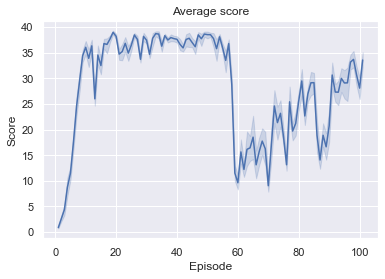

In [3]:
from DDPG_agent import *
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from IPython. display import clear_output
import pandas as pd

#set theme of plot
sns.set_theme(style="darkgrid")

def DDPG_algorithm(env, action_dim, state_dim, brain_name, device, n_episodes=2000, max_t=1000, num_agents = 1):

    #parameter initialization
    scores = {'episode': [], 'score': []} # dataframe containing scores from each episode
    scores = pd.DataFrame.from_dict(scores)
    scores_window = deque(maxlen=5)       # window for moving average
    least_score = 30.0                   # least score for saving of the model
    last_episode = None
    # initialization of DDPG Agent
    agent = DDPGAgent(state_dim, action_dim, device = device) 
    
    # episode section
    for i_episode in range(1, n_episodes+1):
       
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(num_agents)                          # object for score saving
        agent.random_process_fn.reset_states()                # reset noise
        
        for t in range(max_t):
            actions = agent.select_action(states)              # select action for all agents
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            # make step for each agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            score += env_info.rewards                        # update the score (for each agent)
            states = next_states                             # update states
                
            if all(dones):
                break 
                
        scores_window.append(np.mean(score))       # save average score
        clear_output()
        
        # save model with the highest score at least at 30   
        if np.mean(score) >= np.mean(least_score):
            agent.save_model('DDPG_agent')
            least_score = score
            last_episode = i_episode
        
        # print the results for this episode
        print('Episode {:3d} \tScore: {:5.2f} (H: {:5.2f} / L: {:5.2f})\t' \
              'Moving average: {:5.2f} (H: {:5.2f} / L: {:5.2f})' \
              .format(i_episode, score.mean(),
                      score.max(), score.min(),
                      np.mean(scores_window), np.max(scores_window),
                      np.min(scores_window)))
       
        # print last saved model
        if not last_episode == None:
            print('Environment was saved in {:d}. episode.\tAverage Score: {:.2f} (H: {:5.2f} / L: {:5.2f})'\
                  .format(last_episode, np.mean(least_score), np.max(least_score), np.min(least_score)))
        
        # plot data with 95% confidence interval
        dict_score = {'episode': i_episode, 'score': score}
        scores = scores.append(dict_score,  ignore_index = True)
        
        sns.lineplot(data = scores.explode('score', ignore_index = True), x = "episode", y = "score")
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.title('Average score')
        plt.show()
        
    return scores

scores = DDPG_algorithm(env, 4, 33, brain_name, DEVICE, n_episodes=101, max_t=1000, num_agents = 20)

### 4. Plot score of each agent
In this part, there're plot of each agent's training process

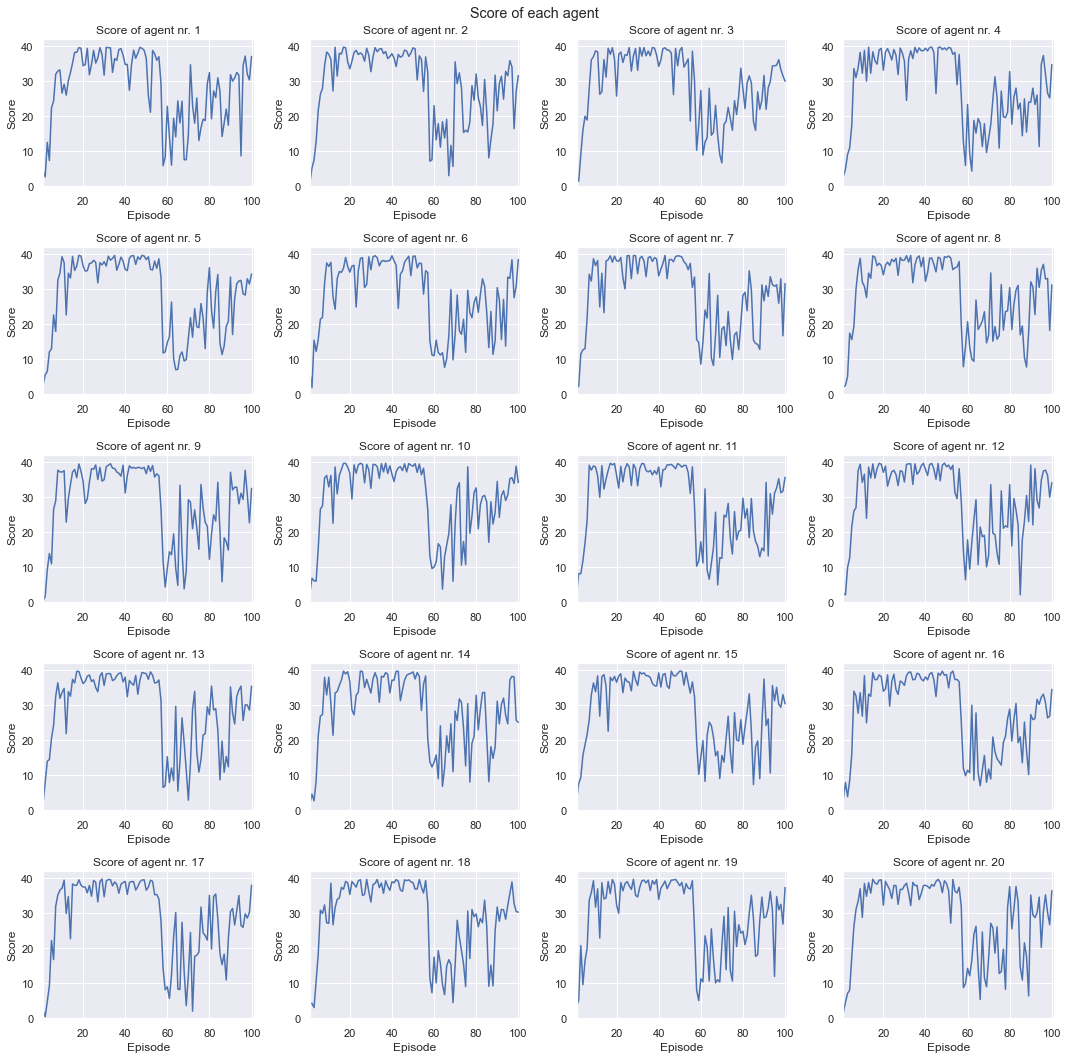

In [27]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), tight_layout=True)
axes = axes.flatten()

fig.suptitle('Score of each agent')
score_array = np.vstack(scores['score'].to_numpy())
for i, column in enumerate(score_array.T):
    sns.lineplot(data = column, ax=axes[i])
    
    # set limits for each axis
    axes[i].set_xlim(1, 101)
    axes[i].set_ylim(0, 42)
    
    #set lable to axis
    axes[i].set_title("Score of agent nr. %d" %(i+1))
    
    # add label to the X-axis
    axes[i].set_xlabel( "Episode")
 
    # add label to the Y-axis
    axes[i].set_ylabel( "Score")

### 5. Testing Neural Network of DDPG Agent

In [ ]:
from DDPG_agent import *
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(20)                                  # initialize the score (for each agent)
agent = DDPGAgent(33, 4, device = device)
agent.load_model('DDPG_agent')
while True:
    actions = agent.select_action(states)
    env_info = env.step(actions)[brain_name]          # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
            
    #score += env_info.rewards                        # update the score (for each agent)
    states = next_states

### 6. Ideas for future work
There could be improved hyperparameters or used better architecture of neural network. There should be used other algorithm e.g. D4PG.